# Air Quality Sensor Results

My wife suffers from moderate to severe eczema which flared up substantially after moving into a new apartment.  One possible cause is indoor air quality, influenced by the boiler room or the carpet.  In the course of pursuing other options, we set up a number of air-quality sensors to record over time.  This shows the main results.  Total voltatile organic compounds were detected in different concentrations that varied substantially over time.  A dedicated formaldehyde sensor similarly had time varying signals.  Opening a window caused such signals to drop precipitously, showing the impact of open ventiliation.  

[Data Clean-up](#cleanup)

[Sensor Correlation](#correlation)

All air sensors interfaced with an Arduino Uno. 

SGP30: an air quality sensor; breakout board by Adafruit
 
SI7021: Humidity and temperature sensor; breakout board by Adafruit.
  
Gravity: Formaldehyde (HCHO) sensor, breakout board by DFRobot; sensor unknown.

MQ-X: a suite of eight different air sensors.   

The SPG30 and Si7021 sensors communicate over I2C; the Gravity
sensor uses UART communication on a single digital pin
(facilitated by SoftwareSerial package).

The MQ sensors are analog output. In order to read all eight
simultaneously, they are digitized by a MCP3008 chip.  

Data was collected between May 28 and July 30, 2019.  On July 31, we moved apartments

In [1]:
import numpy as np
import pandas as pd
import SuitePanda
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import os
import subprocess

import read_formatted

In [17]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

In [6]:
import importlib
importlib.reload(SuitePanda)

/home/rory/Arduino/python/SuitePanda.py:100: UserWarning: registration of accessor <class 'SuitePanda.suite'> under name 'suite' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexistingattribute with the same name.
  class suite(object):


<module 'SuitePanda' from '/home/rory/Arduino/python/SuitePanda.py'>

In [3]:
#find all data files of the type 'suite'
findfiles = subprocess.run(['ls /home/rory/Arduino/python/archive/suite*'],
                            stdout=subprocess.PIPE,
                            shell=True)
fullpaths = findfiles.stdout.decode('utf-8').split('\n')
files = [fullpath.split('python/')[1] for fullpath in fullpaths[0:-2]]

In [12]:
#use older (slower) SuitePanda.fileload function to read data into pandas

#skip improperly formatted file suite20190527.txt
SweetPanda = SuitePanda.fileload(files[1])
for file in files[2:-1]:
    SweetPanda = SweetPanda.append(SuitePanda.fileload(file))
    

KeyboardInterrupt: 

In [4]:
#use newer (faster) read_formatted.read_panda to read data into pandas

justfiles = [f.split('/')[1] for f in files]
SweetPanda = read_formatted.read_panda(justfiles[1])
for f in justfiles[2:]:
    SweetPanda = SweetPanda.append(read_formatted.read_panda(f))

In [5]:
def my_annotate(ax,text,xy=(0,0),xytext=(0,0)):
    ax.annotate(text, 
                xytext=xytext, 
                xy = xy,
                ha='center',
                xycoords='axes fraction',
                fontsize=14,
                arrowprops={'facecolor':'black'})

## Examples of TVOC Spikes

In [3]:
p = read_formatted.read_panda('hcho20190505.txt')

/home/rory/Arduino/python/SuitePanda.py:179: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


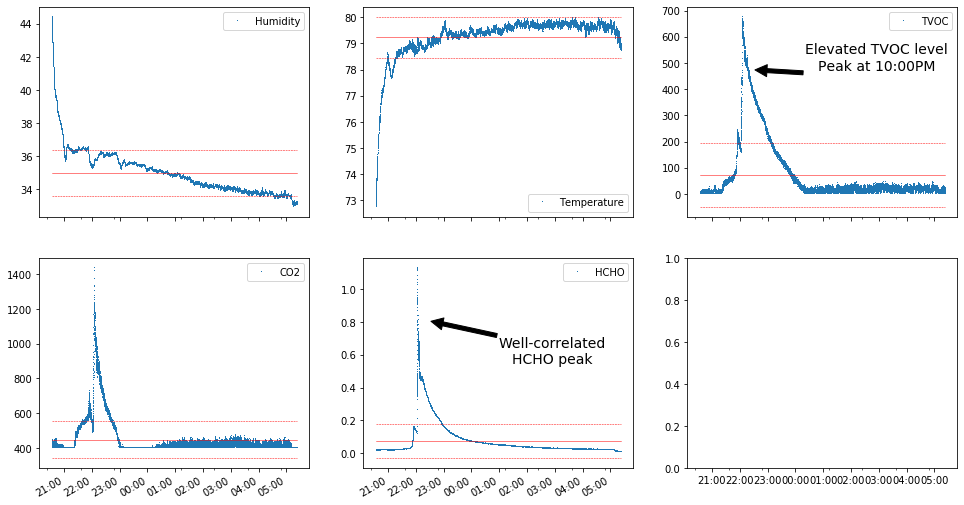

In [6]:
fig,axarr = p.suite.SuitePlot(format='%H:%M')
my_annotate(axarr[0][2], 
            'Elevated TVOC level\nPeak at 10:00PM',
            xytext=(0.7,0.7),
            xy=(0.25,0.7) )
my_annotate(axarr[1][1],
            'Well-correlated\nHCHO peak', 
            xytext=(0.7,0.5),
            xy = (0.25,0.7))

In [26]:
p = read_formatted.read_panda('hcho20190507.txt')

/home/rory/Arduino/python/SuitePanda.py:179: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


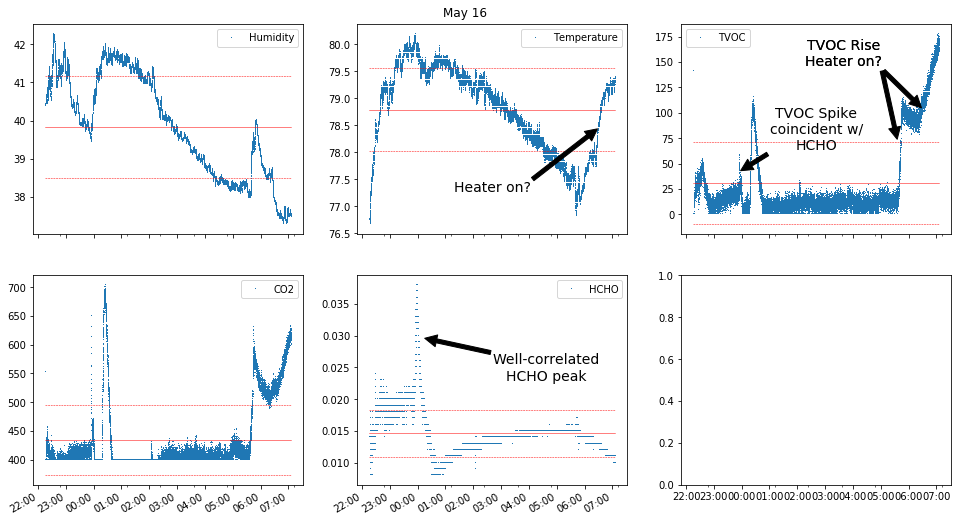

In [35]:
fig,axarr = p.suite.SuitePlot(format='%H:%M')
fig.suptitle('May 16')
#TVOC annotations
my_annotate(axarr[0][2], 'TVOC Spike\ncoincident w/\nHCHO',xytext=(0.5,0.4),xy=(0.22,0.3) )
my_annotate(axarr[0][2], 'TVOC Rise\nHeater on?',xytext=(0.6,0.8),xy=(0.8,0.45) )
my_annotate(axarr[0][2], 'TVOC Rise\nHeater on?',xytext=(0.6,0.8),xy=(0.89,0.6) )
#Temperature annotations
my_annotate(axarr[0][1],'Heater on?', xytext=(0.5,0.2), xy=(0.89,0.5) )
my_annotate(axarr[1][1],'Well-correlated\nHCHO peak', xytext=(0.7,0.5),xy = (0.25,0.7))

In [8]:
p = read_formatted.read_panda('hcho20190516.txt')

/home/rory/Arduino/python/SuitePanda.py:179: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


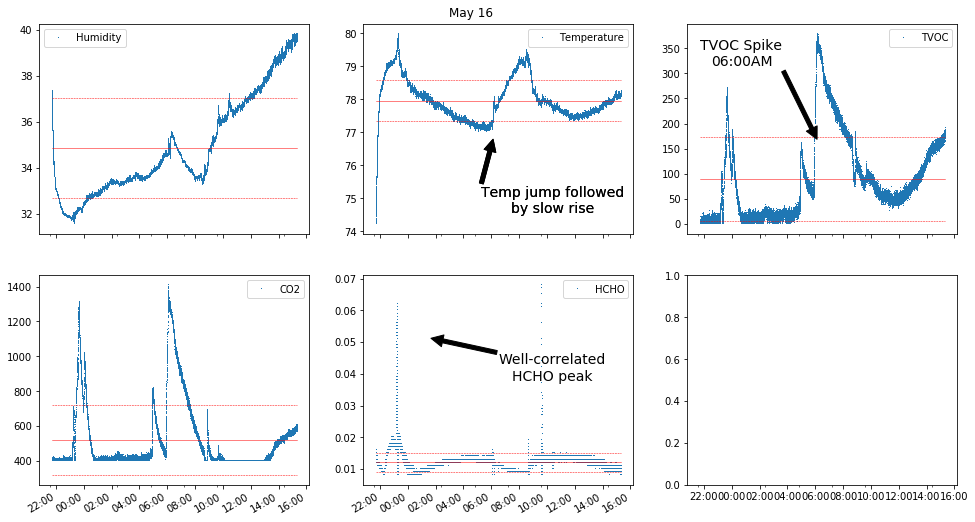

In [23]:
fig,axarr = p.suite.SuitePlot(format='%H:%M')
fig.suptitle('May 16')
my_annotate(axarr[0][2], 'TVOC Spike\n06:00AM',xytext=(0.2,0.8),xy=(0.48,0.45) )
my_annotate(axarr[0][1],'Temp jump followed\nby slow rise', xytext=(0.7,0.1), xy=(0.48,0.45) )
my_annotate(axarr[0][1],'Temp jump followed\nby slow rise', xytext=(0.7,0.1), xy=(0.48,0.45) )
my_annotate(axarr[1][1],
            'Well-correlated\nHCHO peak', 
            xytext=(0.7,0.5),
            xy = (0.25,0.7))

## Data Clean-Up
<a id="cleanup"></a>

There is a bit of data cleanup to do here.  The first involves days on which the MCP3008 ADC was fried.  On such days, the MCP3008 usually returns zero values with occasional values up to the full-scale value (5V).  This can be seen by plotting.

Text(0, 0.5, 'ADC Output (V)')

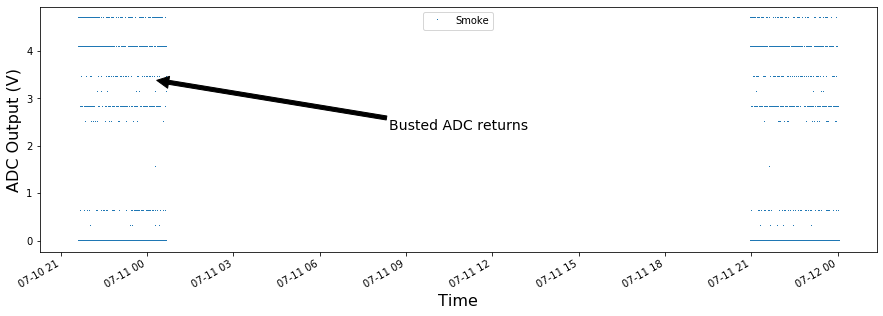

In [5]:
#Lesson in Pandas
#panda.loc['x'] searches for rows labelled 'x'
#apparently, it is quite smart.  Enter a day in MM/DD/YYYY format,
#and it picks out all data points from that day.  It also handles 'slicing'

#Plot 'Smoke' data from two days when ADC was busted
ax = SweetPanda.loc['07/10/2019':'07/12/2019'].plot(y='Smoke', 
                                                    style=',',
                                                    figsize=(15,5))
ax.annotate( 'Busted ADC returns', 
             xytext=(0.5,0.5),
             xy = (0.14,0.7),
             ha='center',
             xycoords='axes fraction',
             fontsize=14,
             arrowprops={'facecolor':'black'})
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('ADC Output (V)', fontsize=16)

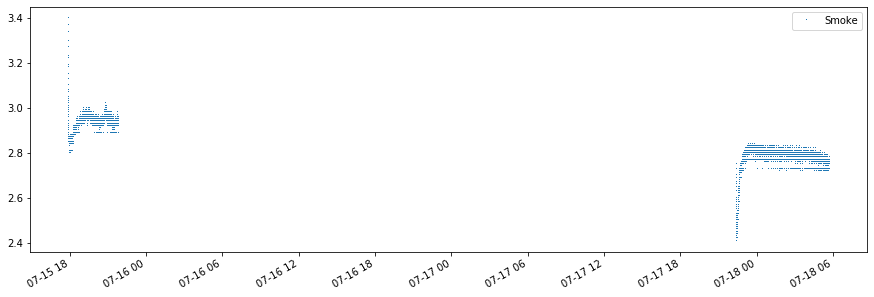

In [6]:
#Demonstrate clean-up 
SweetPanda.loc['07/10/2019':'07/12/2019', 'Smoke'] = np.nan
SweetPanda.loc['07/01/2019':'07/20/2019'].plot(y='Smoke', style=',', figsize=(15,5))

In [17]:
#Second ADC breakage on 07/27 in middle of run, shortly after 16:26, until the move out of 
#the Stonehill apartment on 07/31
SweetPanda.loc['07/27/2019':'07/31/2019'].suite.SuitePlot()
ThisAxis = plt.gca()
ThisAxis.annotate('ADC busted', 
                 xytext=(0.46,0.56),
                 xy = (0.40,0.48),
                 ha='center',
                 xycoords='figure fraction',
                 fontsize=14,
                 arrowprops={'facecolor':'black'})

AttributeError: 'suite' object has no attribute 'suite'

In [20]:
#Now remove all ADC channels for days on which ADC was busted
ADC_channel_names = ['Smoke', 'Alcohol', 'Methane/Propane/Butane', 'LPG', 
                     'CO', 'Hydrogen', 'CO & Methane', 'Ammonia, Sulfide, Benzene']
SweetPanda.loc['07/10/2019':'07/12/2019', ADC_channel_names] = np.nan
SweetPanda.loc['07/27/2019 16:25':'07/31/2019', ADC_channel_names] = np.nan
SweetPanda.loc['06/15/2019':'07/20/2019'].suite.SuitePlot(format='%m/%d')

AttributeError: 'suite' object has no attribute 'suite'

Second type of data clean-up: Arduino occasionally returns abnormally high values.  This happens infrequenly enough that it does not effect the quality of the data.  The most harmful effect is that Python rescales plots to reflect these spuriously high data points, compressing the view of the rest of the (viable) data.  The approach here is to specify a maximum value for each data set, determined by eye after inspecting plots, above which to remove data points.  

In [9]:
MaxVal = {'Humidity':100.,
          'Temperature':100.,
          'TVOC':10000., 
          'CO2':10000., 
          'HCHO':10., 
          'Smoke':5., 
          'Alcohol':5.,
          'Methane/Propane/Butane':1., 
          'LPG':1.0, 
          'CO':1.0, 
          'Hydrogen':1.0, 
          'CO & Methane':1.0,
          'Ammonia, Sulfide, Benzene':5.
         }
for name,val in MaxVal.items():
    SweetPanda.loc[SweetPanda[name] > val, name] = np.nan

In [10]:
#Temperature also has anomalously low data points
SweetPanda.loc[SweetPanda['Temperature'] < 40, 'Temperature'] = np.nan

/home/rory/Arduino/python/SuitePanda.py:169: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


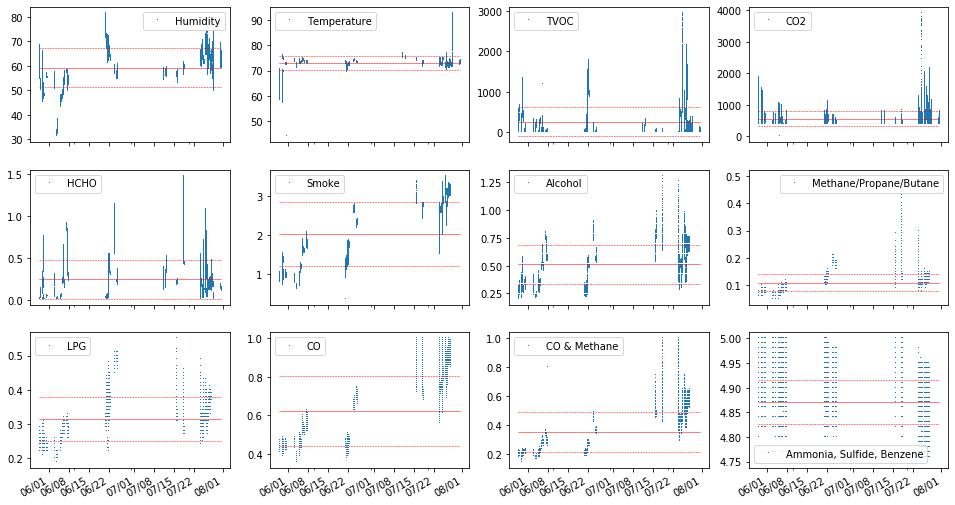

In [11]:
SweetPanda.suite.SuitePlot(format='%m/%d')

## Sensor Correlation
<a id="correlation"></a>

In [30]:
SweetPanda.corr()

,Humidity,Temperature,TVOC,CO2,HCHO,Smoke,Alcohol,Methane/Propane/Butane,LPG,CO,Hydrogen,CO & Methane,"Ammonia, Sulfide, Benzene"
Humidity,1.000000,-0.157045,0.151196,0.033556,0.074168,0.516086,0.256880,0.572101,0.475307,0.467359,0.497830,0.486283,-0.327889
Temperature,-0.157045,1.000000,0.013166,-0.061215,0.103040,0.246851,0.292132,0.145931,0.166226,0.173429,0.103727,0.155302,-0.071042
TVOC,0.151196,0.013166,1.000000,0.628780,0.111520,0.207840,0.135419,0.136285,0.121807,0.166812,0.219765,0.196560,-0.186758
CO2,0.033556,-0.061215,0.628780,1.000000,0.147081,0.133084,0.146069,0.022466,0.054115,0.174824,0.192403,0.199859,-0.121376
HCHO,0.074168,0.103040,0.111520,0.147081,1.000000,0.433190,0.721465,0.512792,0.389783,0.333458,0.156560,0.380197,0.001179
Smoke,0.516086,0.246851,0.207840,0.133084,0.433190,1.000000,0.850413,0.621351,0.596287,0.965926,0.910589,0.970572,-0.449923
Alcohol,0.256880,0.292132,0.135419,0.146069,0.721465,0.850413,1.000000,0.625743,0.622527,0.798629,0.638567,0.823848,-0.268970
Methane/Propane/Butane,0.572101,0.145931,0.136285,0.022466,0.512792,0.621351,0.625743,1.000000,0.896740,0.536165,0.433769,0.561777,-0.221522
LPG,0.475307,0.166226,0.121807,0.054115,0.389783,0.596287,0.622527,0.896740,1.000000,0.548919,0.446322,0.551018,-0.241972
CO,0.467359,0.173429,0.166812,0.174824,0.333458,0.965926,0.798629,0.536165,0.548919,1.000000,0.962247,0.986166,-0.487493


From the giant correlation matrix above, the point of adding the MQ sensors was to determine what, if anything, was correlated with the TVOC and HCHO signals.  

The strongest correlation with TVOC was CO2, but this should be viewed with suspicion, as both measurements come from the same sensor.   TVOC was weakly correlated with a number of the MQ sensors, but the correlation in down around 0.2.

HCHO, on the otherhand, was well correlated with the 'Alcohol' MQ sensor (0.72) and also with Methane/Propane/Butane (0.51) and a number of other sensors at lower levels.  Interestingly, the TVOC and HCHO sensors were not well correlated 

In [34]:
subpanda = SweetPanda[ADC_channel_names]
M = subpanda.corr()

In [8]:
SweetPanda.columns

Index(['Humidity', 'Temperature', 'TVOC', 'CO2', 'HCHO', 'Smoke', 'Alcohol',
       'Methane/Propane/Butane', 'LPG', 'CO', 'Hydrogen', 'CO & Methane',
       'Ammonia, Sulfide, Benzene'],
      dtype='object')

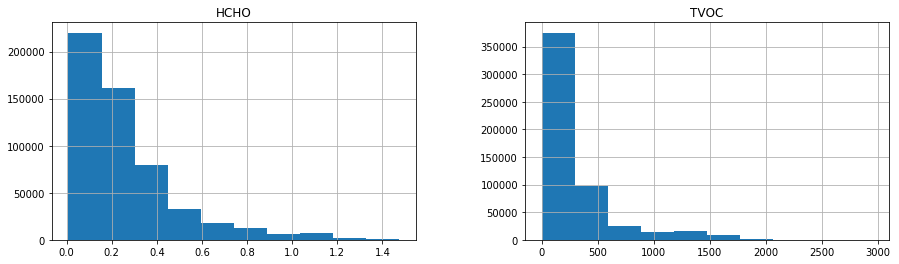

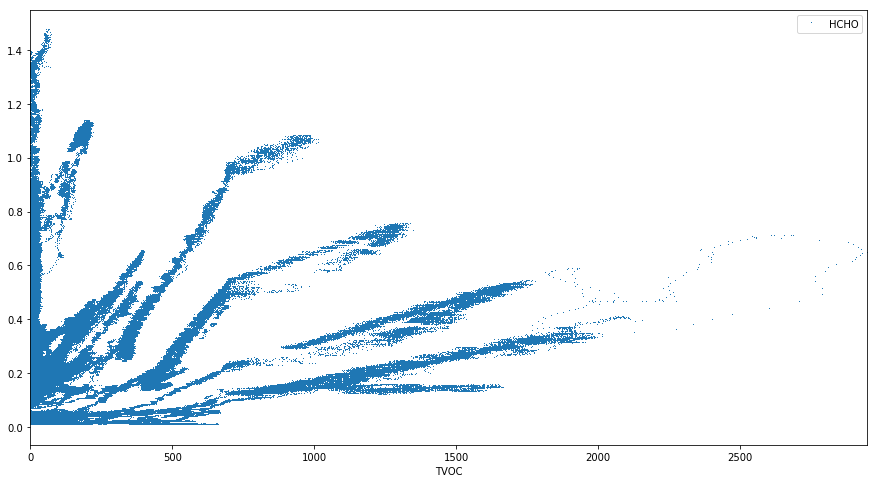

In [37]:
SweetPanda.hist(column=['TVOC','HCHO'],
               figsize=(15,4))
SweetPanda.plot(x='TVOC', y="HCHO", style=',')

Let's try something a little different.  In general, we observe periods of heightened TVOC signals seperated by "uninteresting" periods of low signal.  We can only consider times when the signal is elevated and look for correlation.

In [37]:
subpanda = SweetPanda[SweetPanda.TVOC > 300]
print("subpanda shape: ",subpanda.shape, "vs orginal shape", SweetPanda.shape)

subpanda shape:  (162477, 13) vs orginal shape (562526, 13)


In [38]:
subpanda.corr()

,Humidity,Temperature,TVOC,CO2,HCHO,Smoke,Alcohol,Methane/Propane/Butane,LPG,CO,Hydrogen,CO & Methane,"Ammonia, Sulfide, Benzene"
Humidity,1.000000,0.194083,0.112551,-0.100122,0.285891,0.695307,0.581033,0.792448,0.718927,0.584681,0.581406,0.644423,-0.423035
Temperature,0.194083,1.000000,0.219477,-0.222391,0.257085,0.452755,0.316528,0.237213,0.221034,0.352483,0.324996,0.295138,-0.255035
TVOC,0.112551,0.219477,1.000000,0.307377,0.240258,0.091507,0.236940,0.415130,0.380710,0.000575,-0.051683,0.057093,-0.038017
CO2,-0.100122,-0.222391,0.307377,1.000000,0.484777,0.001060,0.320939,0.074380,0.157916,-0.010998,-0.011488,0.136643,0.068478
HCHO,0.285891,0.257085,0.240258,0.484777,1.000000,0.312145,0.743348,0.559588,0.598970,0.181209,0.113541,0.336821,-0.072040
Smoke,0.695307,0.452755,0.091507,0.001060,0.312145,1.000000,0.810149,0.532851,0.591523,0.973137,0.954327,0.968066,-0.598401
Alcohol,0.581033,0.316528,0.236940,0.320939,0.743348,0.810149,1.000000,0.698383,0.781744,0.777653,0.670065,0.834817,-0.427475
Methane/Propane/Butane,0.792448,0.237213,0.415130,0.074380,0.559588,0.532851,0.698383,1.000000,0.889799,0.366140,0.320493,0.506147,-0.300844
LPG,0.718927,0.221034,0.380710,0.157916,0.598970,0.591523,0.781744,0.889799,1.000000,0.468042,0.404094,0.595268,-0.331765
CO,0.584681,0.352483,0.000575,-0.010998,0.181209,0.973137,0.777653,0.366140,0.468042,1.000000,0.979524,0.988485,-0.588087


Now there is a relativele strong correlation between TVOC and Methane/Propane/Butane and LPG.  

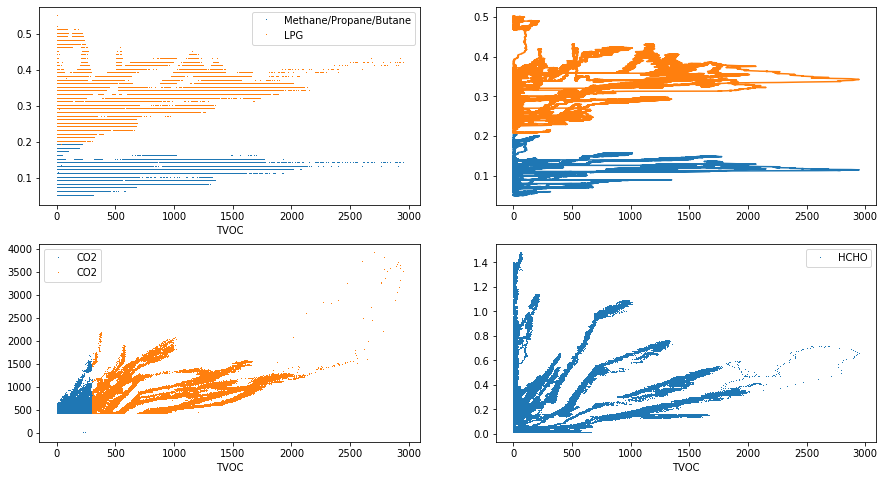

In [52]:
fig,axs = plt.subplots(2,2)
SweetPanda.plot(x='TVOC', y=["Methane/Propane/Butane","LPG"], style=',', ax=axs[0][0])
axs[0][1].plot( SweetPanda.TVOC, SweetPanda['Methane/Propane/Butane'].rolling(window=200).mean())
axs[0][1].plot( SweetPanda.TVOC, SweetPanda.LPG.rolling(window=200).mean())
SweetPanda.plot(x='TVOC', y=["CO2"], style=',', ax=axs[1][0])
subpanda.plot(x='TVOC', y=["CO2"], style=',', ax=axs[1][0])
SweetPanda.plot(x='TVOC', y=["HCHO"], style=',', ax=axs[1][1])


The plot of TVOC vs HCHO is particularly interesting as it indicates that there are times when HCHO is high while TVOC is not.  

In [55]:
subpanda = SweetPanda[SweetPanda.HCHO > 0.2]
print("subpanda shape: ",subpanda.shape, "vs orginal shape", SweetPanda.shape)

subpanda shape:  (257476, 13) vs orginal shape (562526, 13)


In [56]:
subpanda.corr()

,Humidity,Temperature,TVOC,CO2,HCHO,Smoke,Alcohol,Methane/Propane/Butane,LPG,CO,Hydrogen,CO & Methane,"Ammonia, Sulfide, Benzene"
Humidity,1.000000,-0.581059,0.383094,0.387771,-0.005606,0.662158,0.321860,0.483837,0.370497,0.603221,0.695217,0.676063,-0.416519
Temperature,-0.581059,1.000000,0.017772,0.043897,-0.038374,-0.265670,-0.311829,-0.374745,-0.280304,-0.280874,-0.282609,-0.334813,0.215514
TVOC,0.383094,0.017772,1.000000,0.692623,-0.011331,0.042293,-0.152784,0.072983,0.042653,-0.030488,0.118342,0.062120,-0.194943
CO2,0.387771,0.043897,0.692623,1.000000,0.150544,0.301459,0.169013,0.048058,0.080797,0.269191,0.407437,0.381046,-0.291731
HCHO,-0.005606,-0.038374,-0.011331,0.150544,1.000000,0.158689,0.553589,0.346464,0.091406,-0.020289,-0.077886,0.152699,0.111104
Smoke,0.662158,-0.265670,0.042293,0.301459,0.158689,1.000000,0.700812,0.417296,0.328509,0.948542,0.912658,0.973620,-0.364493
Alcohol,0.321860,-0.311829,-0.152784,0.169013,0.553589,0.700812,1.000000,0.451243,0.390664,0.610489,0.480934,0.730229,-0.148471
Methane/Propane/Butane,0.483837,-0.374745,0.072983,0.048058,0.346464,0.417296,0.451243,1.000000,0.880853,0.314384,0.273691,0.379278,-0.113526
LPG,0.370497,-0.280304,0.042653,0.080797,0.091406,0.328509,0.390664,0.880853,1.000000,0.305862,0.276528,0.327143,-0.155411
CO,0.603221,-0.280874,-0.030488,0.269191,-0.020289,0.948542,0.610489,0.314384,0.305862,1.000000,0.966774,0.970804,-0.414253


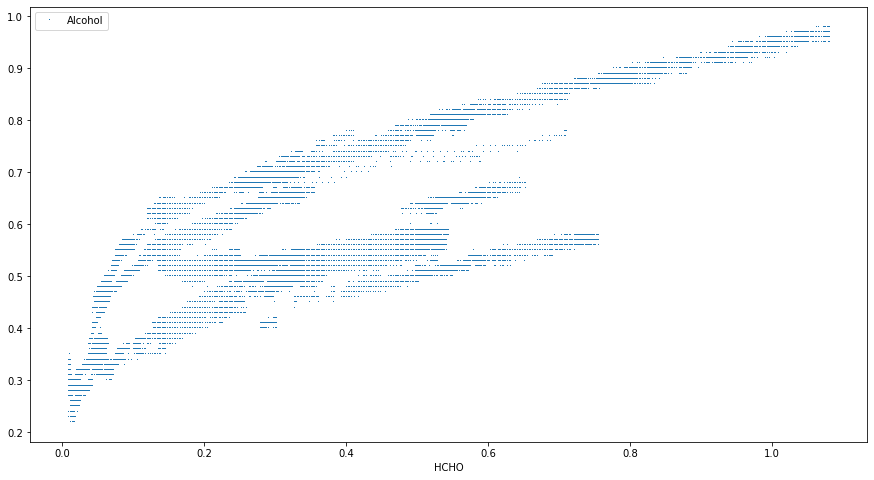

In [29]:
fix,axs = plt.subplots(2,2)
SweetPanda.plot(x='HCHO', y='Alcohol', ax=axs[0][0])
subpanda.plot(x='HCHO', y='Alcohol', style=',', ax=axs[0][0])
SweetPanda.plot(x='HCHO', y='Me', ax=axs[0][0])
subpanda.plot(x='HCHO', y='Alcohol', style=',', ax=axs[0][0])

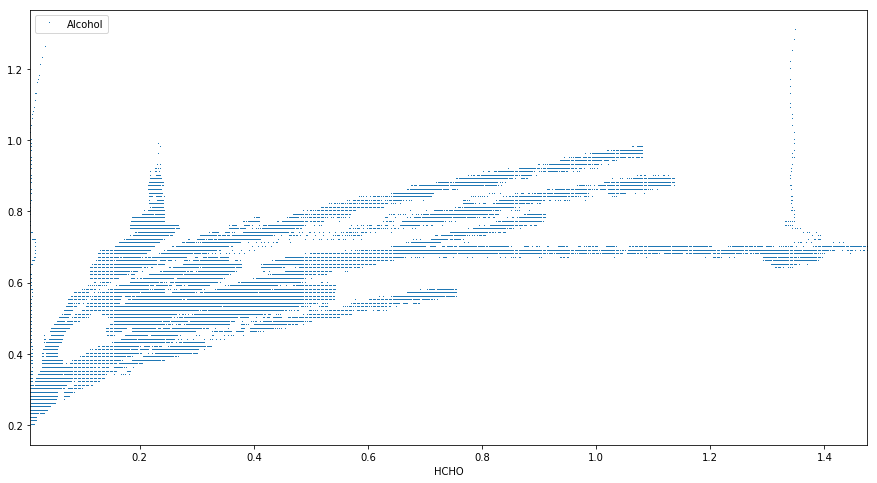

In [38]:
SweetPanda.plot(x='HCHO', y='Alcohol', style=',')

## Daily Plots

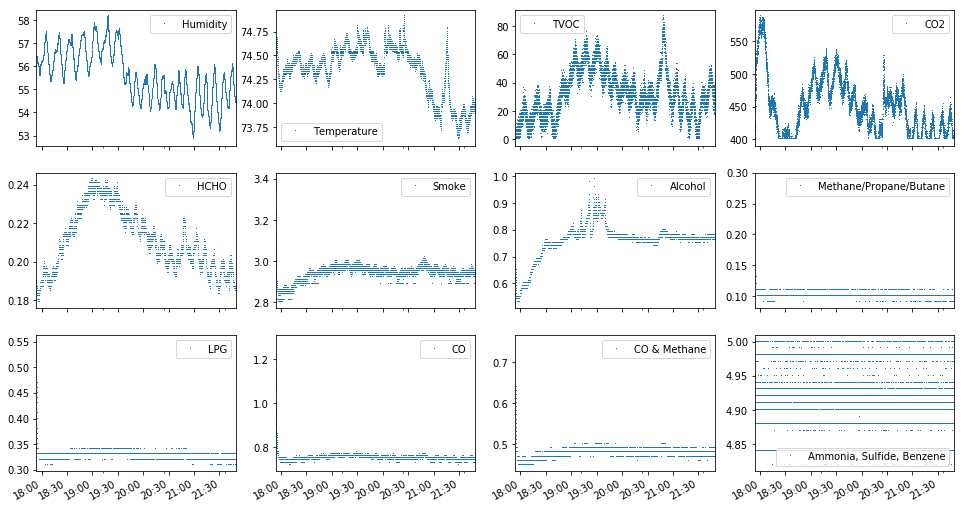

In [14]:
jul15 = SuitePanda.fileload('archive/suite20190715.txt')
jul15.suite.SuitePlot()

/home/rory/Arduino/python/SuitePanda.py:169: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


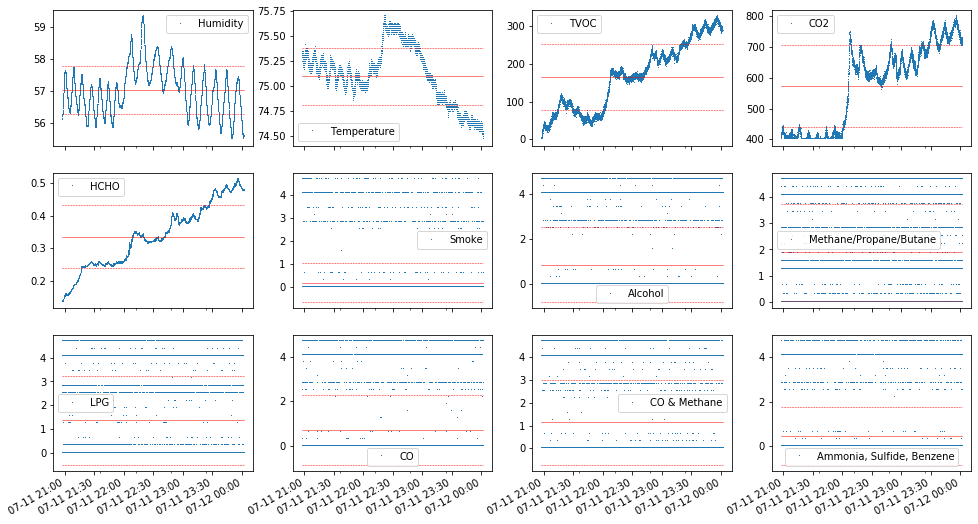

In [28]:
jul11 = SuitePanda.fileload('archive/suite20190711.txt')
jul11.suite.SuitePlot()

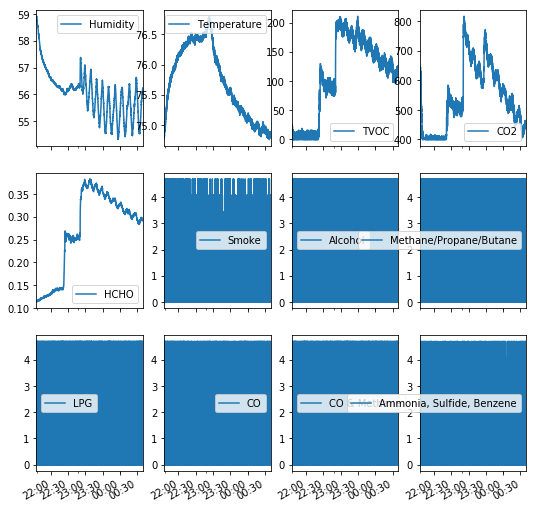

In [22]:
jul10 = SuitePanda.fileload('archive/suite20190710.txt')
jul10.suite.SuitePlot()

In [31]:
midjune = SuitePanda.fileload('archive/suite20190620.txt')
midjune = midjune.append(SuitePanda.fileload('archive/suite20190621.txt'))
midjune = midjune.append(SuitePanda.fileload('archive/suite20190623.txt'))
midjune = midjune.append(SuitePanda.fileload('archive/suite20190624.txt'))

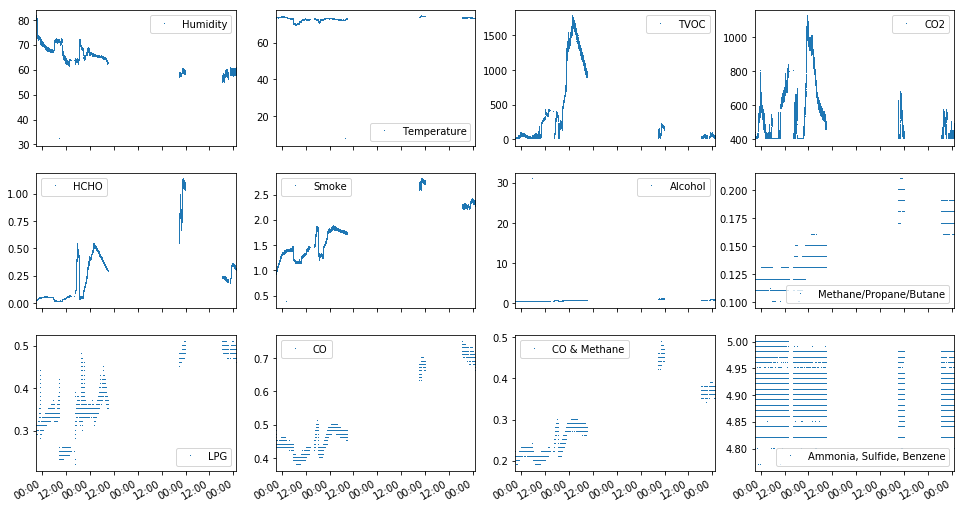

In [22]:
midjune.suite.SuitePlot()

In [28]:
earlyjune = SuitePanda.fileload('archive/suite20190602.txt')
for day in ['3','4','5','7']:
    earlyjune = earlyjune.append(SuitePanda.fileload('archive/suite2019060'+day+'.txt'))


/home/rory/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


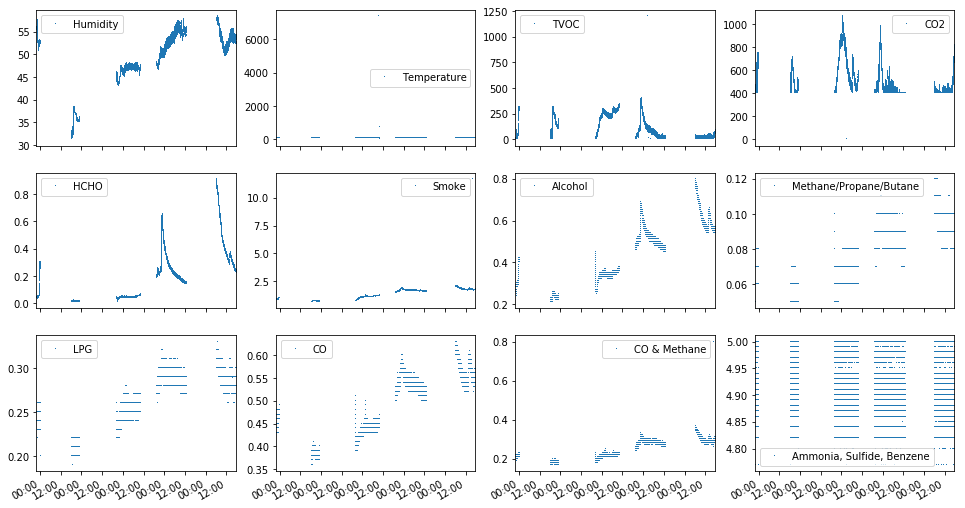

In [29]:
earlyjune.suite.SuitePlot()

In [44]:
#march = SuitePanda2.fileload('archive/suite20190528.txt')
#march = march.append(SuitePanda2.fileload('archive/suite20190529.txt'))
#march = march.append(SuitePanda2.fileload('archive/suite20190530.txt'))
may = SweetPanda.loc['2019-05-01':'2019-05-31']

/home/rory/Arduino/python/SuitePanda.py:169: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


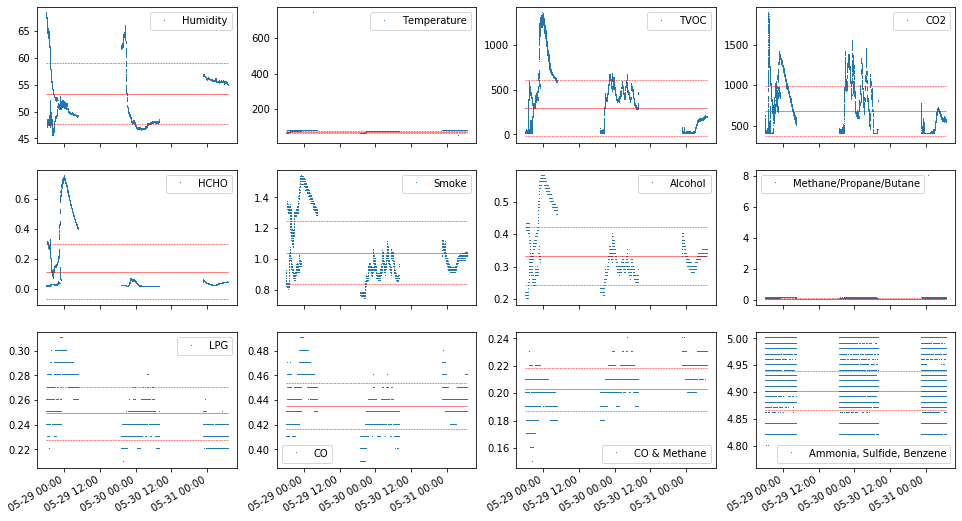

In [45]:
may.suite.SuitePlot()

In [32]:
may.index[0]

Timestamp('2019-05-28 17:52:38')